# AP 157: Meeting 2
### Instructor: Louie Rubio

##### Date: 02/22/23

##### Key Words:
thermalization - process of approaching equilibrium <br>
autocorrelation - account for this by taking values only between every nth Montecarlo sweep 

##### Hamiltonian
\begin{equation}
H = - \sum_{<i,j>} J_{ij} s_i s_j - B\sum_{i} s_i,
\label{Hamiltonian}
\end{equation}

##### Magnetization

\begin{equation}
\left<m\right> = \frac{1}{N^2} \sum_{i}\left<s_i\right>,
\end{equation}

##### On energy difference
\begin{align}
H &= - \sum_{<i,j>} J_{ij} s_i s_j - B\sum_{i} s_i, \\
\Delta H &= H_f - H_i  \\
&= - J\sum_{<k,l>} s_k s_l - B\sum_{k} s_k + J\sum_{<i,j>} s_i s_j + B\sum_{i} s_i
\label{Hamiltonian}
\end{align}
Note that these two hamiltonians all cancel out, save for a few terms involving the substituted spin:
\begin{align}
&= -s_{1}(s_l - s_i) - s_{2}(s_l - si) - s_{3}(s_l - s_i) - s_{4}(s_l - s_i) - B(s_l - s_i)\\
\end{align}
But $s_l = -s_i$, and so:
\begin{align}
&= s_{1}(2s_i) + s_{2}(2s_i) + s_{3}(2s_i) + s_{4}(2s_i) + B(2s_i)\\
\end{align}

In [1]:
import numpy as np

#returns an N \times N lattice
def ini_lattice(N):
    '''
    1. parameter 1 ensures function returns random integer from set {0,1}
    2. multiplying by 2 generates integers from set {0,2}
    3. subtracting 1 shifts set to {-1,1}
    4. parameter 2 sets generated values to N \times N array
    '''
    S = 2*np.random.randint(2,size=(N,N))-1
    return S

#returns energy of a lattice
def H_lattice(S,J = 1,B = 0):
    """
    1. we calculate products of nearest neighbours first along rows, and then along columns
    2. np. roll shifts elements by 1 index, so that nearest neighbour elements are multiplied; periodic boundary conditions are satisfied
    """
    #interaction energy of each spin; we've explicitly assumed interactions are isotropic
    J_row = J*np.sum(S* np.roll(S,shift=1,axis=1))
    J_col = J*np.sum(S* np.roll(S,shift=1,axis=0))
    inter_energy = J_row + J_col
    
    #energy contributed by interaction with magnetic field
    mag_energy = B*np.sum(S)
    
    E = - (inter_energy + mag_energy)
    
    return E

#returns energy difference between final and intial config if some site S[i][k] was flipped
def delta_H(S,i,k,J=1,B=0):
    #modulo operator takes care of PBCs
    N = len(S)
    site_inter_energy = J*(S[i][k])* (S[(i+1)%N][k] + S[(i-1)%N][k] + S[i][(k+1)%N] + S[i][(k-1)%N])
    site_mag_energy = B*(S[i,k])
    
    return 2*(site_inter_energy + site_mag_energy)

#attempts a flip and returns a boolean if accepted, along with change in energy
def attempt_flip(S,beta,i,k,J=1,B=0):
    p_reject = np.random.rand(1)
    
    delta_E = delta_H(S,i,k)
    if delta_E <= 0:
        return True,delta_E
    else:
        return np.exp(-beta*delta_E)>p_reject, delta_E
    
def sweep(S,beta,J=1,B=0):
    N = len(S)
    
    #generate N**2 random indices
    #using list comprehension
    x_rands = [np.random.randint(0,N) for i in range(0,N**2)]
    #using numpy
    y_rands = np.random.randint(N,size=N**2)
    
    #save the total changed energy and magnetization per sweep
    delta_E_sweep = 0
    delta_m_sweep = 0
    for site_flip in range(0,N**2):
        i = x_rands[site_flip] 
        k = y_rands[site_flip]
        
        check, delta_E = attempt_flip(S,beta,i,k)
        
        if check:
            delta_E_sweep += delta_E
            S[i][k] *= (-1)
            delta_m_sweep += 2*S[i][k]/(N**2)
        else:
            pass
    return S, delta_E_sweep, delta_m_sweep

In [2]:
def generate_Points(S, beta,mcs= 3000):
    E_list, m_list = [],[]
    #initial energy of lattice
    E_list.append(H_lattice(S))
    #initial magnetization
    m_list.append(np.sum(S)/(N**2))
    for sweep_count in range(1,mcs):
        S, e, m = sweep(S,beta)
        E_list.append(E_list[sweep_count-1] + e)
        m_list.append(m_list[sweep_count-1] + m)
    return E_list, m_list

In [3]:
N = 64
S = ini_lattice(N)
S_ini = S.copy()
T = 1
y1, y2 = generate_Points(S, T)

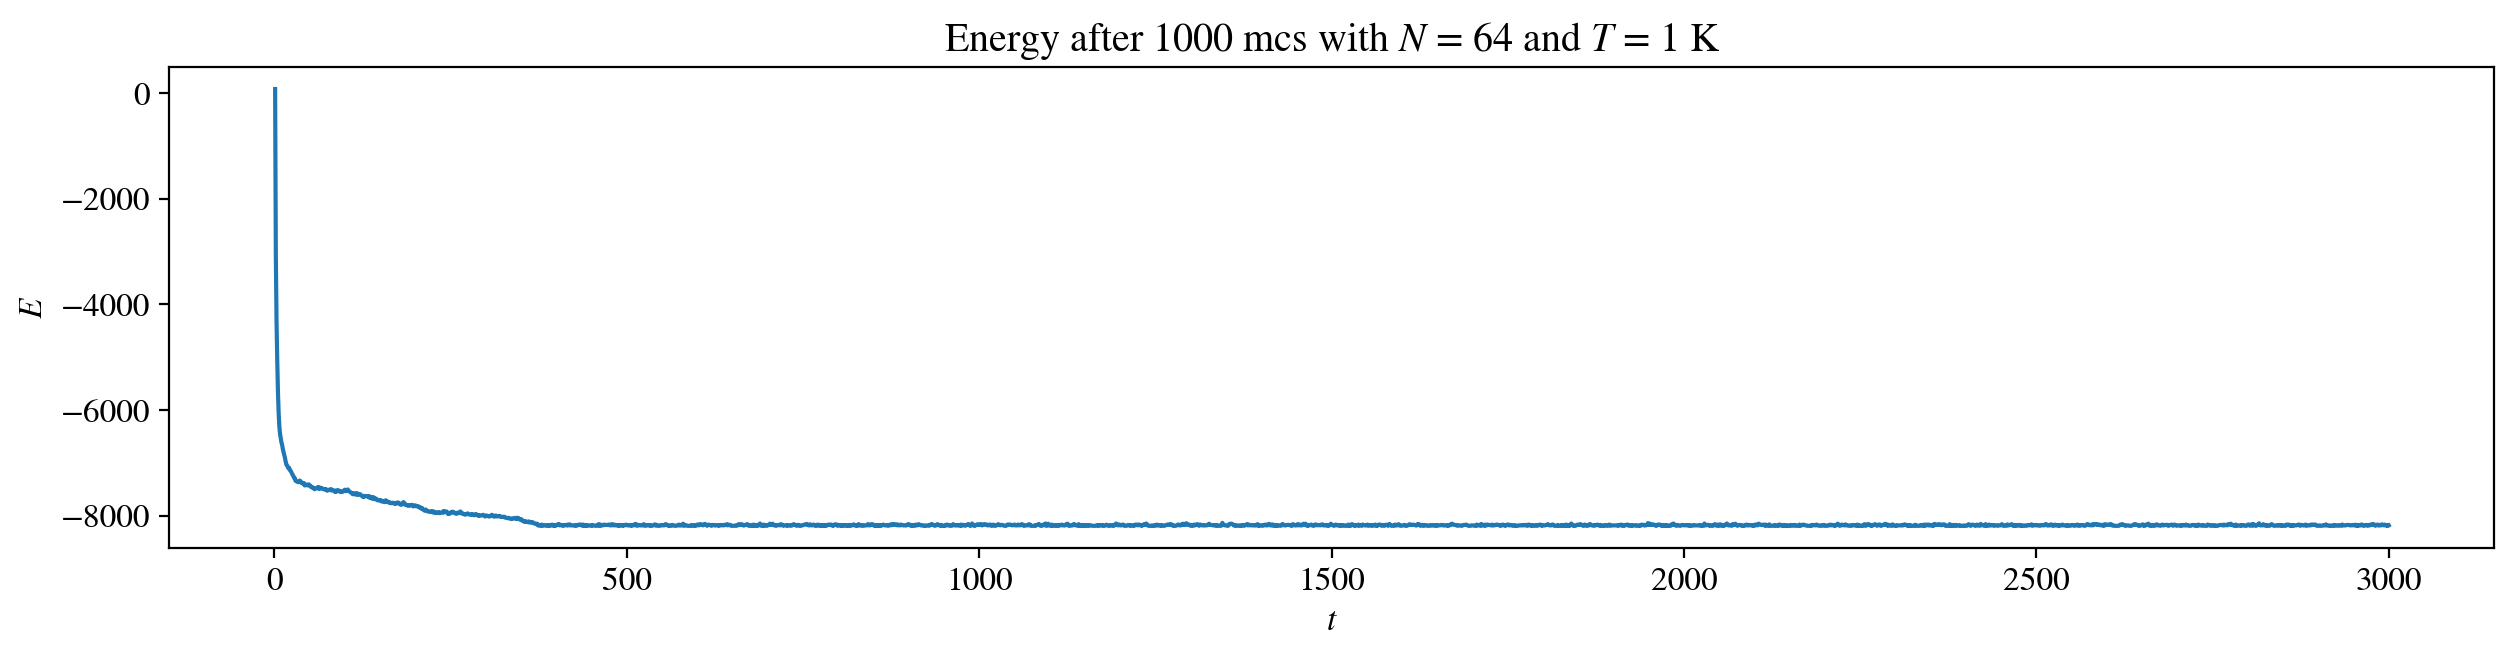

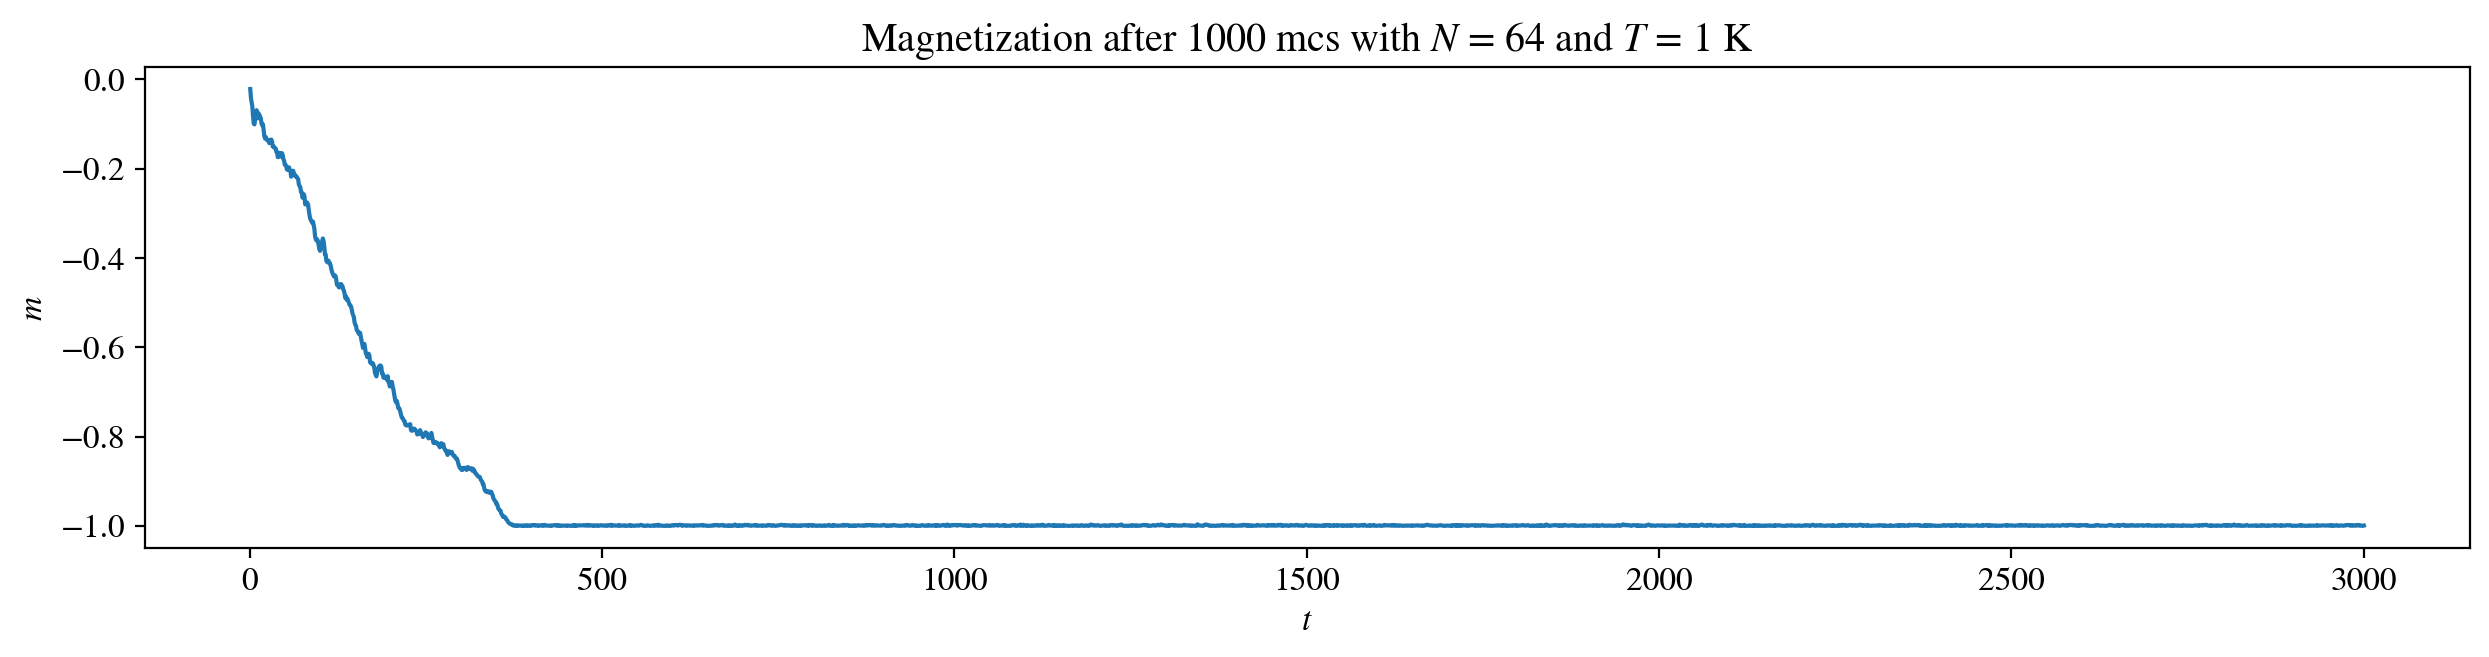

In [5]:
import matplotlib.pyplot as plt
steps = np.linspace(1,3000,3000)

%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 7]
plt.rcParams['lines.markersize'] = 10
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['figure.dpi'] = 200
plt.rcParams['font.size'] = 12
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams['mathtext.fontset'] = 'stix'

fig = plt.figure()

plt.subplot(2, 1, 1)
plt.plot(steps,y1)
plt.title(r"Energy after 1000 mcs with $N$ = {}".format(N) + " and $T$ = {}".format(T) + " K")
plt.xlabel(r"$t$")
plt.ylabel(r"$E$")
plt.show()

plt.subplot(2, 1, 2)
plt.plot(steps,y2)
plt.title(r"Magnetization after 1000 mcs with $N$ = {}".format(N) + " and $T$ = {}".format(T) + " K")
plt.xlabel(r"$t$")
plt.ylabel(r"$m$")
plt.show()


newparams = {'figure.figsize': (15, 7), 'axes.grid': False,
             'lines.markersize': 10, 'lines.linewidth': 2,
             'font.size': 15, 'mathtext.fontset': 'stix',
             'font.family': 'STIXGeneral', 'figure.dpi': 200}

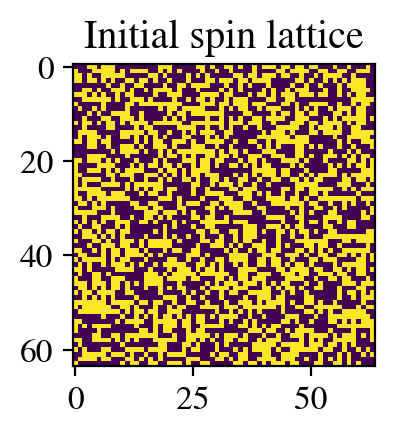

In [6]:
plt.rcParams['figure.figsize'] = [2,2]
fig = plt.figure()
plt.title(r"Initial spin lattice")
plt.imshow(S_ini)

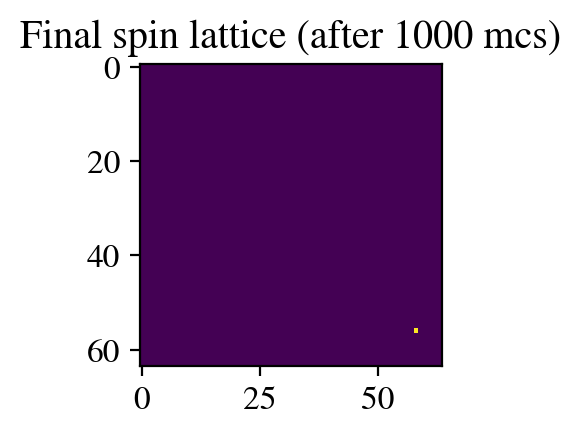

In [7]:
plt.rcParams['figure.figsize'] = [2,2]
fig = plt.figure()
plt.title(r"Final spin lattice (after 1000 mcs)")
plt.imshow(S)

In [8]:
import scipy.optimize

def auto_corr_func(t, tau):
    """Dummy function declariation that is needed to use the curve_fit function from the scipy library. 
    
        Parameters:
            t: The enumuration of the Monte Carlo sweeps 
            tau: Correlation time
        Returns:
            chi: exp(-t / tau)
        """
    chi = np.exp(-t / tau)
    return chi


def correlation_time(arr):
    """Calculates the estimator for the autocorrelation function, chi, as a function of t. Stops the calculations
    of chi when chi(t) becomes egative. Then calculates the correlation time by using the curve_fit
    function from scipy-library.
    
        Parameters:
            arr: The measurement series we want to determine the correlation time of
        Returns:
            tau: The correlation time
            chi: The autocorrelation function as a function of # Monte Carlo sweeps. The size of the array varies.
        """
    chi = np.zeros(0)
    n = np.minimum(len(arr), 10000)
    # Here we take the minimum of the length of the array, and 10000 to obtain a correlation time that is
    # independant of the length of the array
    for t in range(n):
        frac = (1 / (n - t))
        
        # plus 1 to include last term
        expectation_0 = frac * np.sum(arr[:(n - 1 - t) + 1])
        expectation_t = frac * np.sum(np.roll(arr, - t)[:(n - 1 - t) + 1])
        
        temp = frac * np.sum((arr[:n - 1 - t + 1] - expectation_0) *
                             (np.roll(arr, - t)[:n - 1 - t + 1] - expectation_t))
        if temp < 0:
            break
        chi = np.append(chi, temp)
    # Normalize the autocorrelation function
    chi = chi / chi[0]
    t = np.arange(0, len(chi))
    # Calculates the correlation time with scipy
    tau = scipy.optimize.curve_fit(auto_corr_func, t, chi)[0]
    return tau[0], chi

Tau is equal to 1.1 when T =  1  K


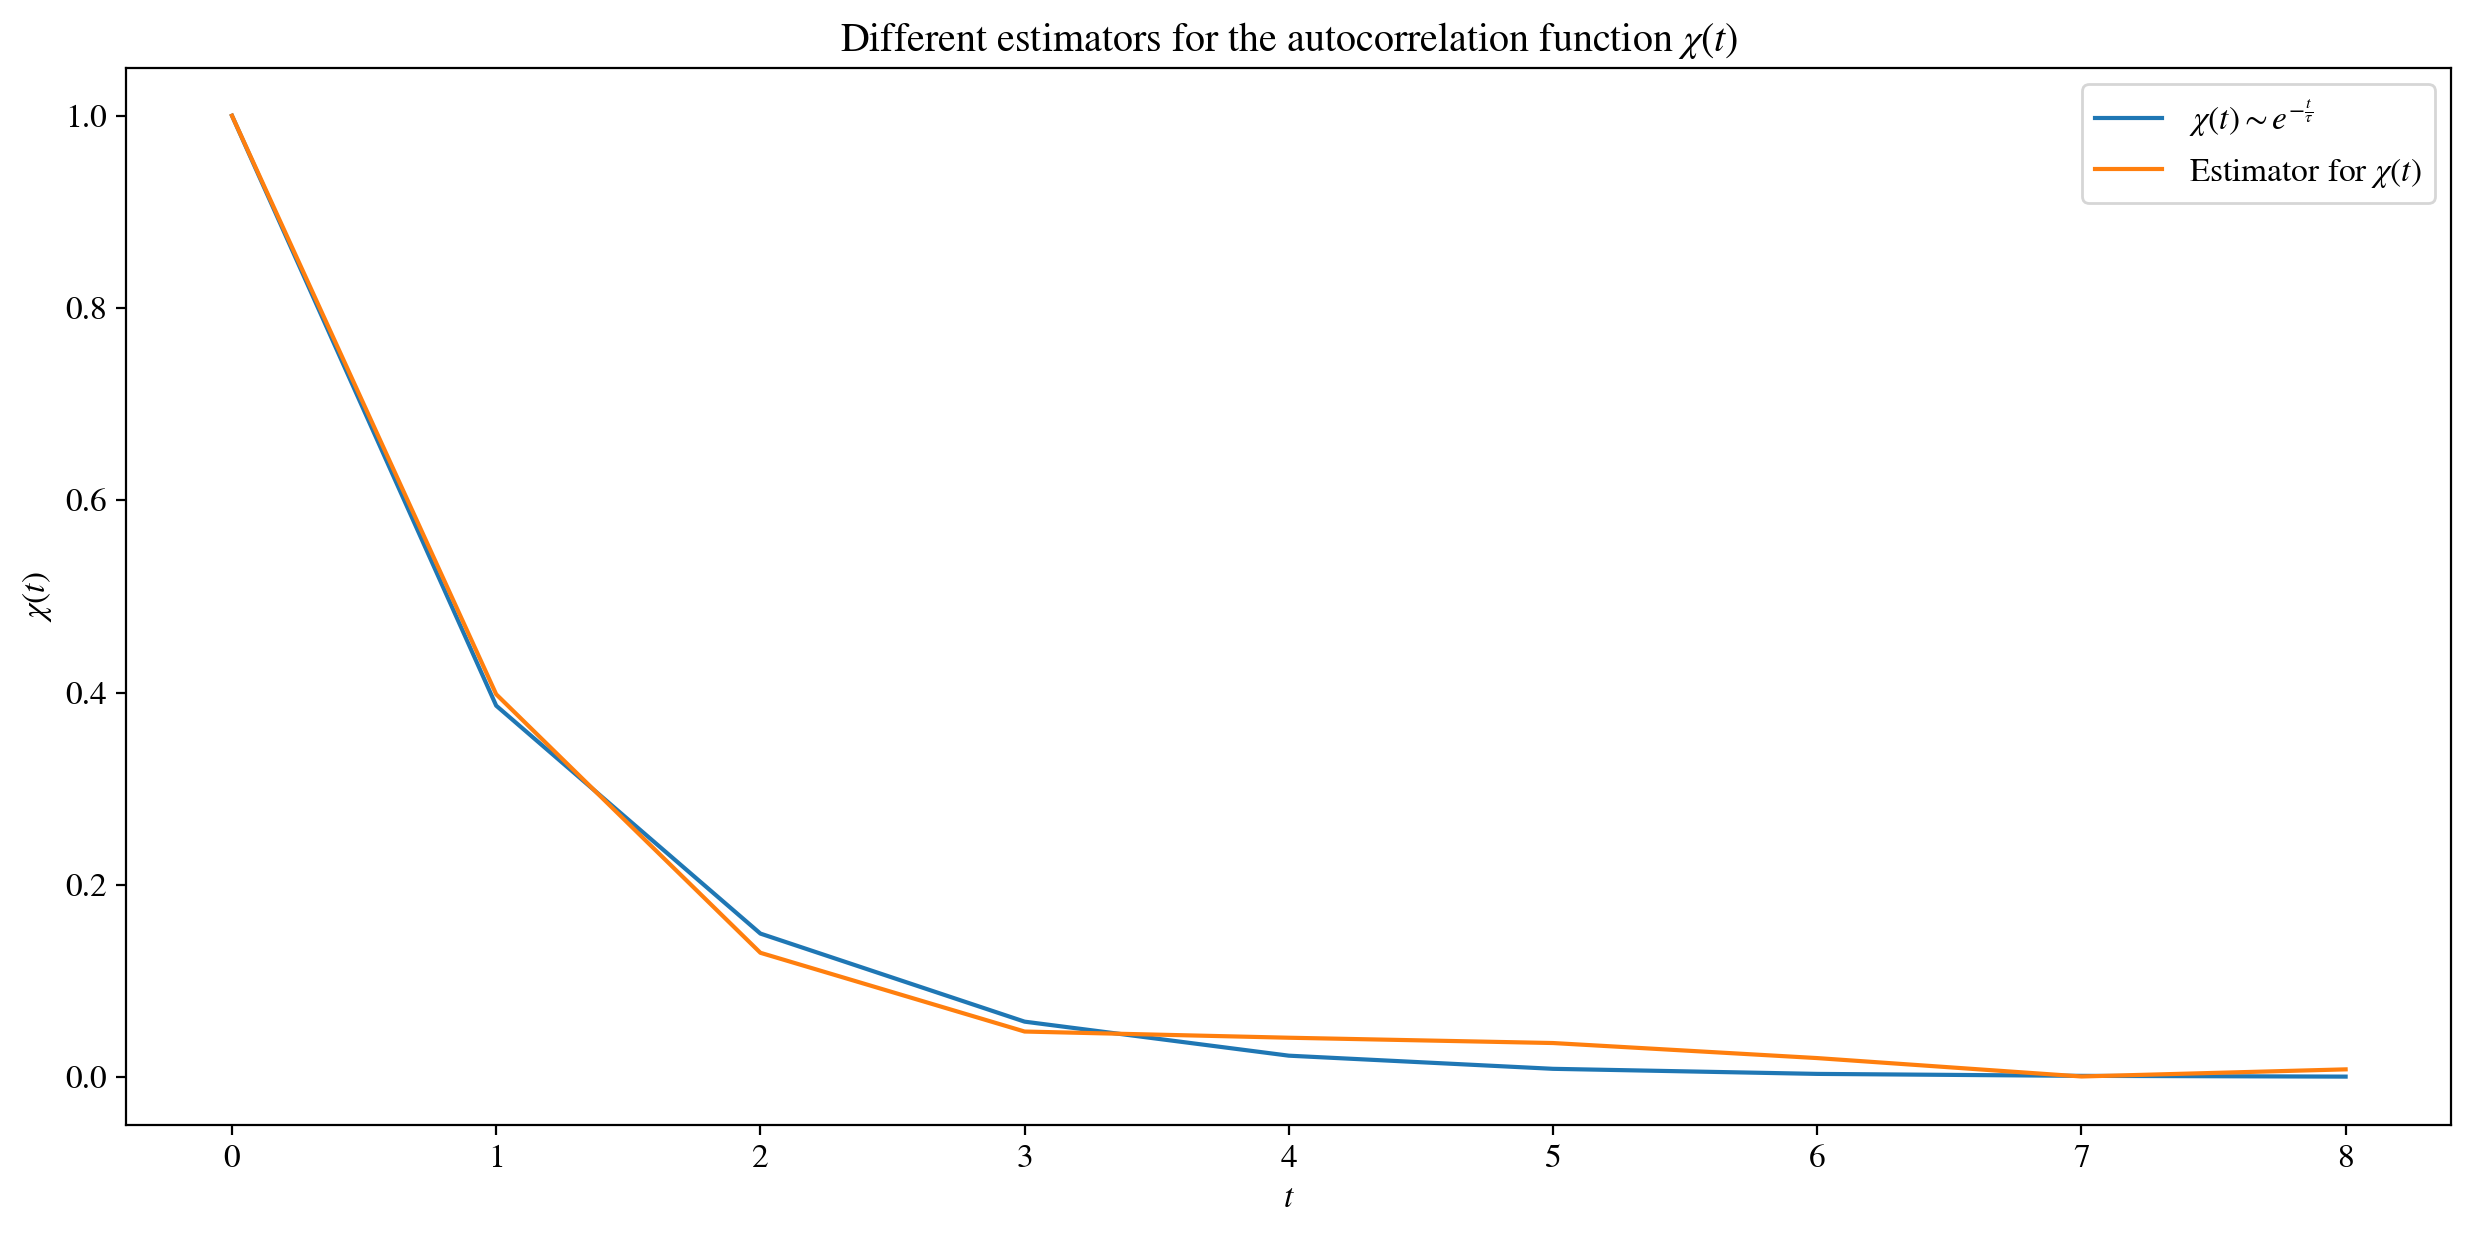

In [9]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 7]
plt.rcParams['lines.markersize'] = 10
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['figure.dpi'] = 200
plt.rcParams['font.size'] = 12
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams['mathtext.fontset'] = 'stix'

tau, chi = correlation_time(y2[600:])
t = np.arange(len(chi))
print("Tau is equal to " + "%.1f" % tau + " when T = ", T, " K" )
plt.plot(t, np.exp(- t / tau), label= r"$\chi(t) \sim e^{- \frac{t}{\tau}}$")
plt.plot(t, chi, label = "Estimator for $\chi(t)$")
plt.legend()
plt.title(r"Different estimators for the autocorrelation function $\chi(t)$")
plt.xlabel(r"$t$")
plt.ylabel(r"$\chi(t)$")
plt.show()